# AIRPI Demonstration Notebook
So far there is only a working interface for hdf5-files. We assume a 4D-STEM hdf5-dataset with the dimension [xr, yr, xk, yk]. The real space dimension may be swapped. This can be specified in the script. You may download an example dataset to work with from our Zenodo repository:

## Download Example Dataset

In [3]:
import requests

url = "https://zenodo.org/record/7034879/files/STO_small.h5"
response = requests.get(url, allow_redirects=True)
open('example_sto.h5', 'wb').write(response.content)

117969856

## Select GPU to use
This step is optional. By default the program will use the first GPU on your system. If you have only one, don't worry about this.

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Imports

In [1]:
import logging
import os
# Supress annoying Info and Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Import necessary airpi functions and classes
from ap_reconstruction.airpi_dataset import airpi_dataset
from ap_reconstruction.reconstruction_functions import load_model, retrieve_phase_from_generator
from ap_utils.file_ops import load_hparams

## Specify sample parameters and reconstruction options

In [2]:
hd5_in = "example_sto.h5"       # Path to dataset
hd5_key = "ds"                  # hdf5 key, specifying the dataset in the hdf5 file
rec_prms = {
    "E0": 300.0,                # Acceleration Voltage [keV]
    "apeture": 20.0,            # Apeture angle [mrad]
    "gmax": 1.6671,             # Maximum collection angle [1/A] (only used if probe_estimation_method = 'gene')
    "cbed_size": 64,            # Size of the CBEDs in pixels
    "step_size": 0.1818,        # Scan step size [A]
    "aberrations": [-1, 1e-3],  # Aberrations [C1, C3] C1==-1 computes the Scherzer defocus for the given C3
    "probe_estimation_method": 'avrg',
    # Aperture function estimation
    #       'gene': parameter generated(E0, apeture, gmax, aberrations) 
    #       'avrg': use PACBED to estimate a probe function (E0, apeture, aberrations) 
    "oversample": 2.0,          # Oversampling factor of the output reconstruction
    "order": ['rx','ry']        # Specify real space order of the dataset
}
options={'threads':1, 'batch_size':256} # Parameters for Performance

ds_class = airpi_dataset(rec_prms, hd5_in, hd5_key) # Interface Object

## Build the model

In [3]:
cp_path = os.path.join('Ckp','Training','V_32_D3_sk_r10')   # Model weights
hp_file = os.path.join(cp_path, "hyperparameters.pickle")   # Model parameters
prms_net = load_hparams(hp_file)[1]
prms_net["cp_path"] = cp_path

model = load_model(prms_net, ds_class.ds._flat_shapes[0], options['batch_size'], ds_class.rec_prms['probe']);

Use checkpoint: Ckp/Training/V_32_D3_sk_r10
Model: "UNET_32_D3_N5_A3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 standardization__layer__dep  multiple                 0         
 loyed (Standardization_Laye                                     
 r_Deployed)                                                     
                                                                 
 convolution__block (Convolu  multiple                 3328      
 tion_Block)                                                     
                                                                 
 contraction__block (Contrac  multiple                 46880     
 tion_Block)                                                     
                                                                 
 contraction__block_1 (Contr  multiple                 185920    
 action_Block)                                                   
      

## Run the reconstruction
Note, that a live update is not supported in jupyter notebook, but only in plain python execution mode. The image will be presented here when the process has finished though.

REC: 100%|██████████| 3600/3600 [00:01<00:00, 1993.43 samples/s]


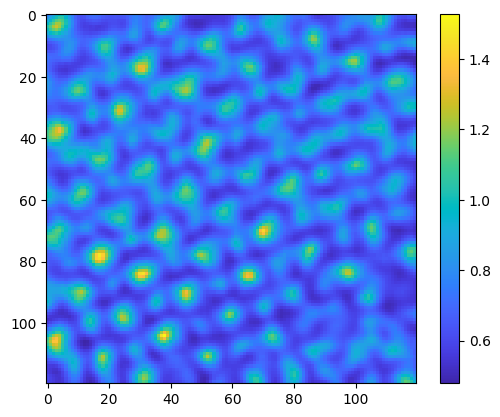

In [7]:
ds_class = airpi_dataset(rec_prms, hd5_in, hd5_key) # Interface Object
obj = retrieve_phase_from_generator(ds_class, options=options, model=model, live_update=True)